In [2]:
# Import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

## Data Processing

In [3]:
# Load the dataset
df = pd.read_csv('UsArrests.csv')
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)
relevant_missing_values = pd.DataFrame(missing_values, columns=["missing"])
relevant_missing_values
# There values are no missing so we can carry on

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64


,missing
City,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


There values are no missing so we can carry on without further action.

In [5]:
print('Number of cases: {} Number of features: {}'.format(df.shape[0],df.shape[1]))

Number of cases: 50 Number of features: 5


In [6]:
# Determine the data type of each variable.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [7]:
# Set the decimal precision at 2 points in float format
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

In [8]:
#The describe function gives insight into the statistical qualities of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() 
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


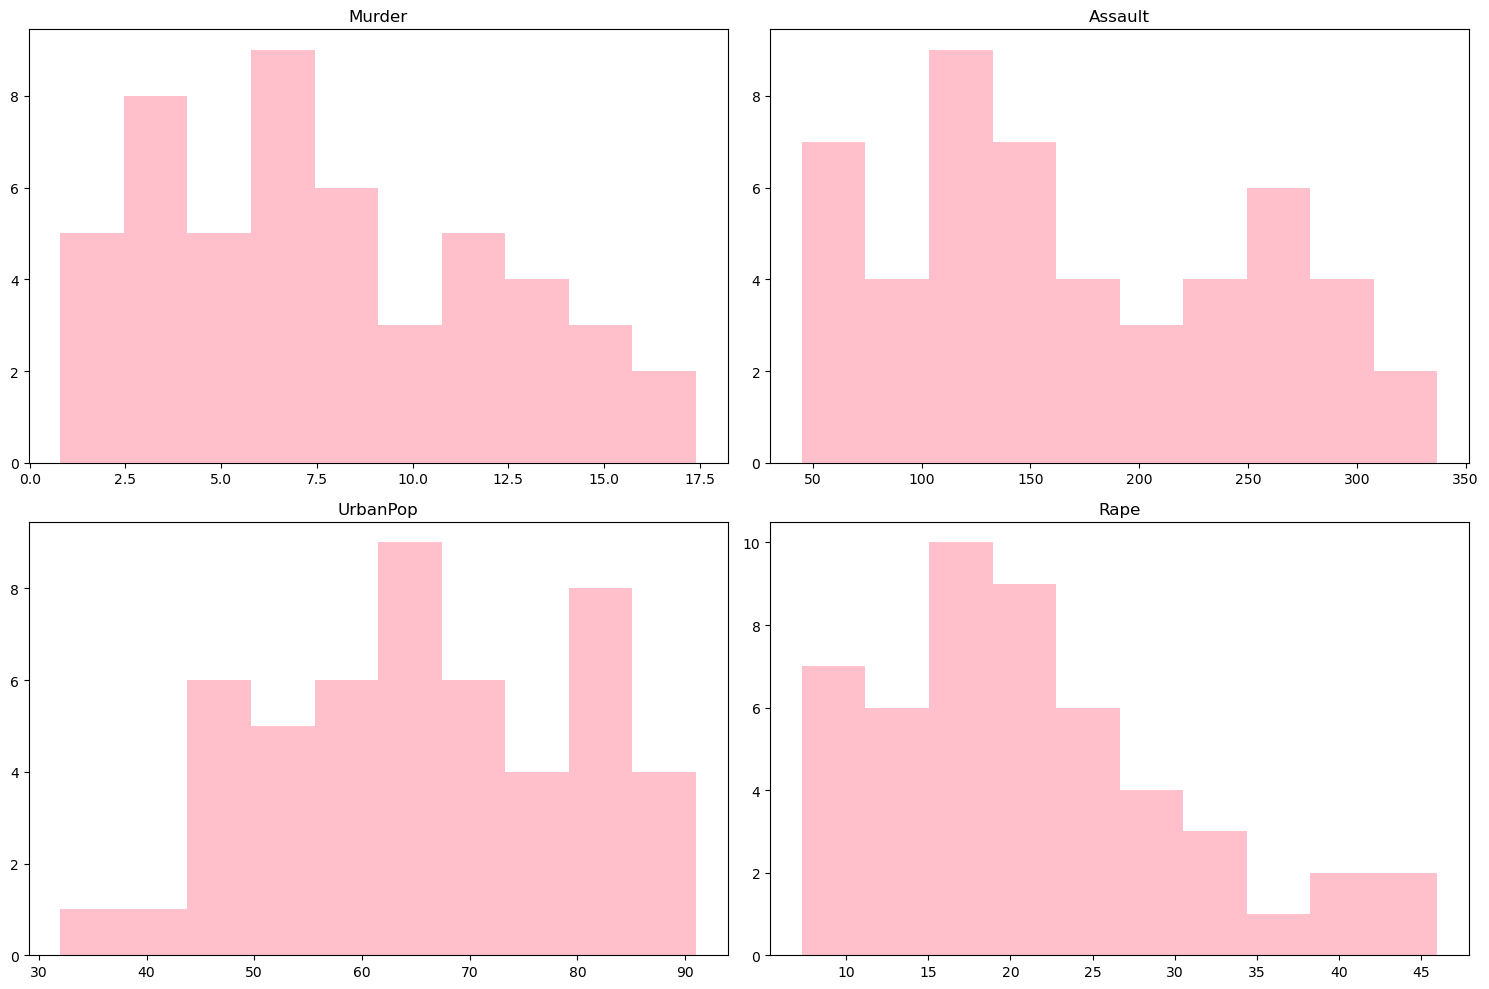

In [9]:
# Histograms give a general idea on the distribution of crimes/arrests committed throughout the USA states
histograms = df.hist(color='pink', grid=False, figsize=(15, 10)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()

It is evident that the crimes are not normally distributed as all the histograms above do not have the classic bell shape. Since PCA works under the assumption that the data is normally distributed, then it is necessary to standardise the data also because PCA is sensitive to variance of variables.

In [10]:
# Extract the 'State' column and drop it from the DataFrame before scaling
states = df['City']
df.drop('City', axis=1, inplace=True)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

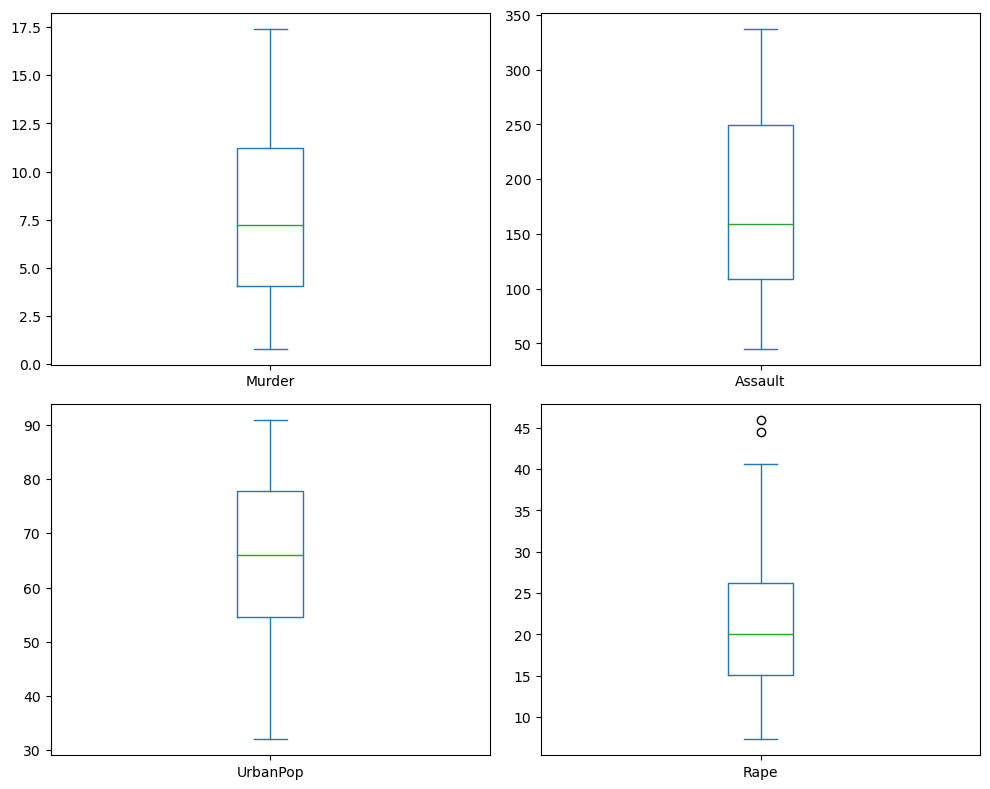

In [22]:
# Create boxplots
df.plot(kind='box', subplots=True, layout=(2,2), figsize=(10,8))
plt.tight_layout()
plt.show()

The boxplots indicate that there are some outliers in the data, particularly for the assault rate which could affect variances, in turn influencing the PCA.

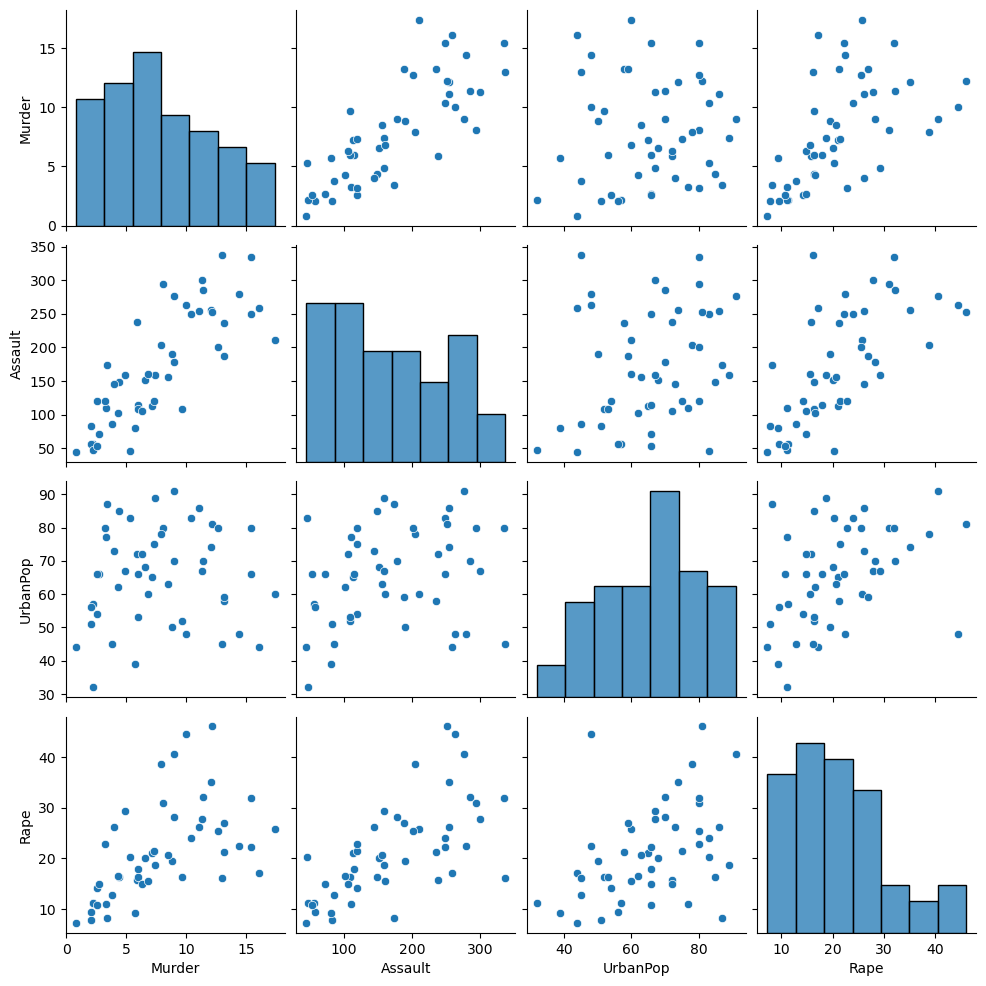

In [23]:
# Create scatterplots
sns.pairplot(df)
plt.show()

<Axes: >

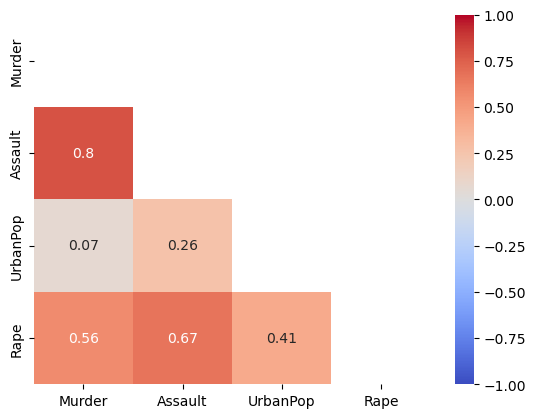

In [11]:
cities = df.index
corr_df = df.corr()
labels =corr_df.columns

correlations = corr_df.corr()

mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool_)
sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True,fmt='.2g', mask=mask_ut, cmap="coolwarm")

From the correlation matrix above, one can see that all the variables are positively correlated besides one pair namely UrbanPop and Murder. This indicates that if there is a high rate of one kind of crime in an area, then it is expected that area is susceptible to kinds of crime rates. Assault and Murder have the strongest positive correlation of 0.8. Assault and Rape have a strong positive correlation of 0.67. Highly correlated variables can result in multicollinearity, which can affect the results of PCA. The strongly correlated variables can be removed or combined into a single variable. Rape and Murder have a moderately strong positive correlation of 0.56. Rape and UrbanPop share a weaker positive correlattion of 0.41. Assault and UrbanPop have a weak positive correlation of 0.26. 

Overall this shows that this data is not a fit candidate for a PCA because there are not many variables that have strong (negative or positive) correlations with one another.

# Principal Component Analysis

Principal Components Analysis (PCA) is a method for finding the underlying variables, namely the principal components, that best charaterise the observations determining the directions along which the data points have the most variance; therefore variables with higher variance than that of the other variables influence the PCA due to their scale. PCA is method to reduce dimensionals which is useful when there are many variables.

In [12]:
# Fit PCA
pca = PCA()
principal_components = pca.fit_transform(scaled_data)
df_std_pca = pd.DataFrame(principal_components)
df_std_pca.head()

,0,1,2,3
0,0.99,1.13,-0.44,0.16
1,1.95,1.07,2.04,-0.44
2,1.76,-0.75,0.05,-0.83
3,-0.14,1.12,0.11,-0.18
4,2.52,-1.54,0.60,-0.34


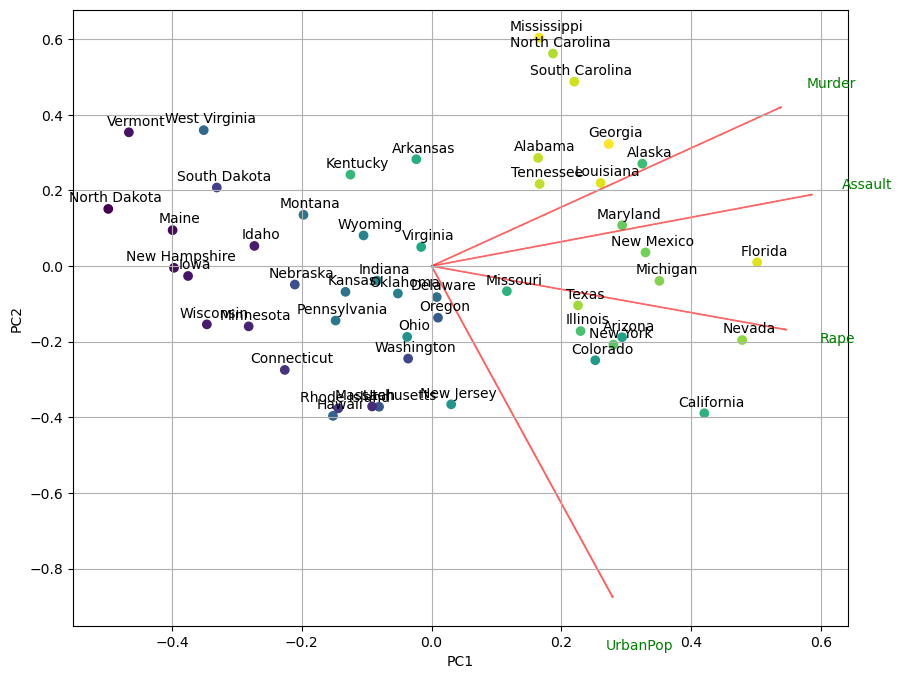

In [13]:
# Create a biplot using matplotlib
def biplot(score, coeff, labels=None, target_feature=None):
    plt.figure(figsize=(10, 8))
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    
    # Set color of data points based on the target feature (optional)
    if target_feature is not None:
        c = df[target_feature]
        target_label_mapping = {val: idx for idx, val in enumerate(sorted(c.unique()))}
        c = [target_label_mapping[val] for val in c]
    else:
        c = 'blue'
    
    plt.scatter(xs * scalex, ys * scaley, c=c, cmap='viridis')
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, df.columns[i], color='g', ha='center', va='center')
        else:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='g', ha='center', va='center')
    
    # Annotate data points with state names
    for i, state in enumerate(states):
        plt.annotate(state, (xs[i] * scalex, ys[i] * scaley), textcoords="offset points", xytext=(5,5), ha='center')
    
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()
    plt.show()

# Call the biplot function and choose 'Murder' as the target feature for coloring the data points
biplot(principal_components[:, 0:2], np.transpose(pca.components_[0:2, :]), list(df.columns), target_feature='Murder')

Each point representing a city on the biplot above is the projected observation which has been transformed from the initial dataset. The importance the features is determined by the length of the arrows on the biplot which correspond to the magnitude of the repective eigenvectors. Assault and UrbanPop are the most important variables as the arrows to each of these are the longest in the biplot.

In [14]:
# Feature importance
pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.54,0.42
1,Assault,0.58,0.19
2,UrbanPop,0.28,0.87
3,Rape,0.54,0.17


The most significant feature for PC1 is Assault and for PC2 it is UrbanPop, each of which dominate their PC with over 0.9 importance.

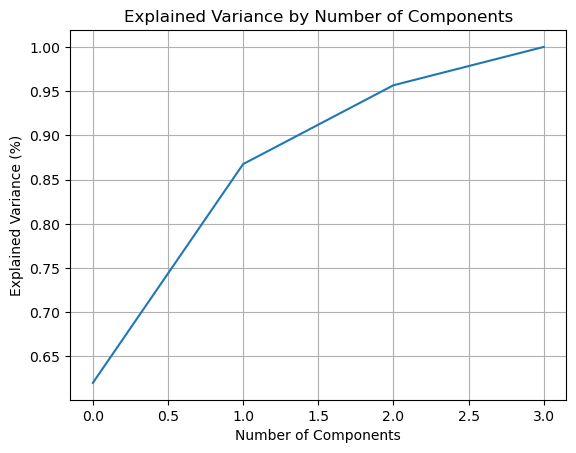

In [15]:
# Analyze explained variance
explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by Number of Components')
plt.grid()
plt.show()

The explained variance plot obtained from PCA provides insight on how much information is captured by the principal components, thus the significance of each component in representing the overall variability in the data. 
The first two components represent most of the variability in the data at 90%, while the third and fourth components capture much less variance. In this case, it may be reasonable to consider using only the first two components for further analysis and visualization as it suggests that the data can be represented in a lower-dimensional space.

The variance reaches over 0.9 between 2 and 3 components.

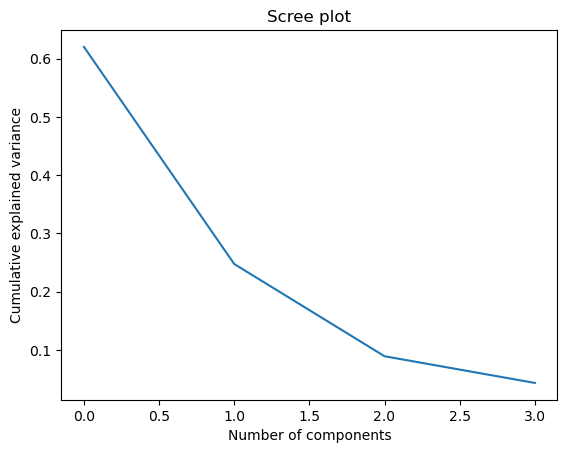

In [16]:
# Scree plot
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("Scree plot")
plt.show()

The cree plot is a graphical representation of the explained variance of each principal component in a PCA analysis. It helps further gauge the importance of each component and identify the number of components needed to capture a substantial portion of the data's variability.

If the first few components have high explained variance ratios, it suggests that these components capture most of the data's variability. In such cases, a lower-dimensional representation of the data can be achieved by retaining only these components.

The number of components to retain can be determined based on the "elbow" point in the plot. The elbow point is the point where the explained variance stops increasing significantly and levels off. It serves as a guide to choose the optimal number of components for dimensionality reduction. In this case the elbow occurs at two components.

In [17]:
pca_df = pd.DataFrame(principal_components[:,0:2], index = df.index)
pca_df.head()

,0,1
0,0.99,1.13
1,1.95,1.07
2,1.76,-0.75
3,-0.14,1.12
4,2.52,-1.54


# Hierarchical Clustering

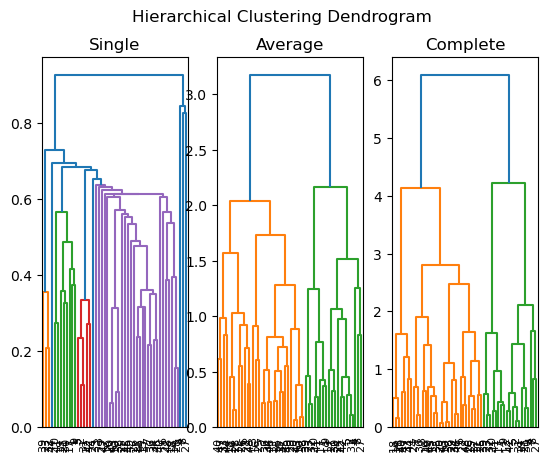

In [18]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()



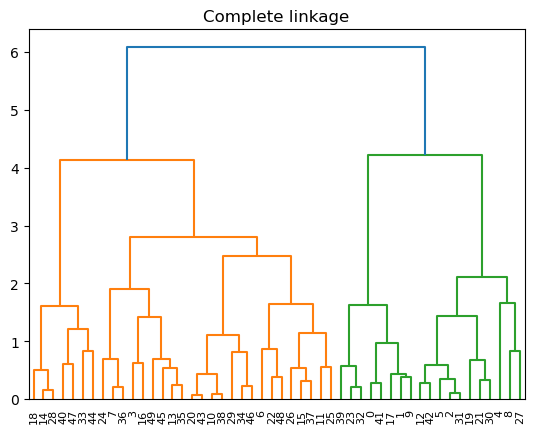

In [19]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()


The above dendrograms illustrate the hierarchical merging of data points into clusters based on their distances. The height at which branches are merged provides insights into the distances between data points and the forming of clusters.

The aim of visualizing multiple dendrograms with different linkage methods is to compare how the clustering structure varies under different linkage criteria. The choice of linkage method can greatly influence the resulting clusters and is an significant aspect of hierarchical clustering.

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


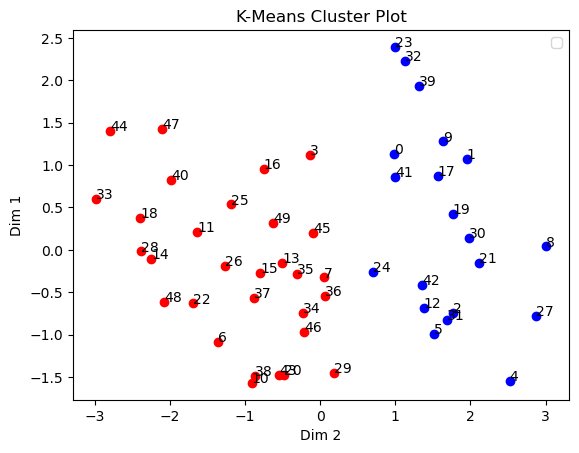

In [21]:
# We extract the first two components
x = principal_components[:,0]
y = principal_components[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
center = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i], c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means Cluster Plot")
ax.set_xlabel("Dimension 2")
ax.set_ylabel("Dimension 1")
ax.legend()

The K-means clustering divided the cities into two groups (clusters) where the cites in the blue group have more crime than those in the red group.